# Getting started with Gammapy

## Introduction

This is a getting started tutorial for [Gammapy](http://docs.gammapy.org/).

It shows an application example for the following classes:

- [gammapy.data.EventList](http://docs.gammapy.org/en/latest/api/gammapy.data.EventList.html)
- [gammapy.catalog.SourceCatalog](http://docs.gammapy.org/en/latest/api/gammapy.catalog.SourceCatalog.html)
- [gammapy.image.SkyImage](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyImage.html)
- [gammapy.spectrum.SpectralModel](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.SpectralModel.html), TODO: and other spectrum classes.
- [gammapy.time.LightCurve](http://docs.gammapy.org/en/latest/api/gammapy.time.LightCurve.html)

We will also work with the following Astropy classes:

- `astropy.table.Table` - See the [astropy.table docs](http://astropy.readthedocs.io/en/latest/table/index.html).
- `astropy.coordinates.SkyCoord` - See the [astropy.coordinates docs](http://astropy.readthedocs.io/en/latest/coordinates/index.html)
- `astropy.time.Time` - See the [astropy.time docs](http://astropy.readthedocs.io/en/latest/time/index.html)

We will use the [Second Fermi-LAT Catalog of High-Energy Sources (2FHL) catalog](http://fermi.gsfc.nasa.gov/ssc/data/access/lat/2FHL/)
and corresponding event list and have a look at an image, spectrum and light curve for the brightest sources.

## Setup

First, as usual with IPython notebooks and Python, we need to do some setup and imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.catalog import source_catalogs

## Dataset

- Load 2FHL catalog, select brightest sources.
- Load event list, cone select events and print some stats

In [3]:
cat = source_catalogs['2fhl']
table = cat.table
table.sort('TS')
table = table[::-1]
table[:9][['Source_Name', 'ASSOC', 'CLASS']].pprint()

   Source_Name       ASSOC     CLASS
----------------- ------------ -----
2FHL J1104.4+3812      Mkn 421   bll
2FHL J0534.5+2201         Crab   pwn
2FHL J1653.9+3945      Mkn 501   bll
2FHL J1555.7+1111  PG 1553+113   bll
2FHL J2158.8-3013 PKS 2155-304   bll
2FHL J0507.9+6737 1ES 0502+675   bll
2FHL J1427.0+2348 PKS 1424+240   bll
2FHL J0222.6+4301       3C 66A   bll
2FHL J1015.0+4926  1H 1013+498   bll


## Images

- Read a SkyImage from a fits file, smooth it and plot it
- Reproject a SkyImage onto the WCS of another one

(<matplotlib.figure.Figure at 0x1116d8e90>,
 None)

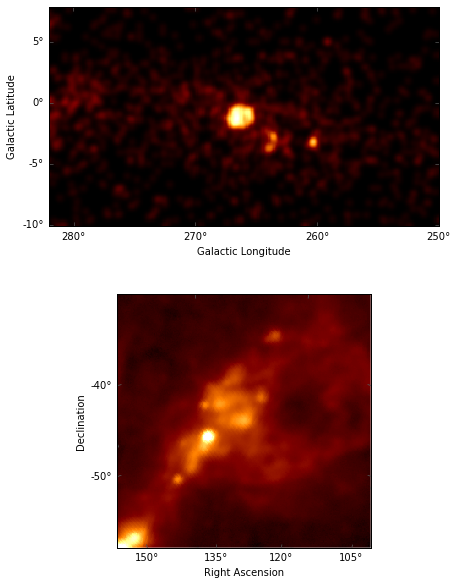

In [4]:
from gammapy.image import SkyImage

vela_2fhl = SkyImage.read("$GAMMAPY_EXTRA/datasets/fermi_2fhl/fermi_2fhl_vela.fits.gz",ext=2)
vela_smooth = vela_2fhl.smooth('gauss',1)

vela_wmap = SkyImage.read("$GAMMAPY_EXTRA/datasets/images/Vela_region_WMAP_K.fits")

# Now plot
fig = plt.figure(figsize=(7,10))
ax1 = fig.add_subplot(2, 1, 1, projection=vela_smooth.wcs)
vela_smooth.plot(ax=ax1,cmap='afmhot')

ax2 = fig.add_subplot(2, 1, 2, projection=vela_wmap.wcs)
norm = vela_wmap.plot_norm(stretch='sqrt',max_percent=99.9)
vela_wmap.plot(ax=ax2,cmap='afmhot',norm=norm)



The projection of the WMAP image is tangential in radec system.  We want to align the two images. We therefore reproject the WMAP one.

We also keep only a cutout around the Vela position.

(<matplotlib.figure.Figure at 0x111d387d0>,
 None)

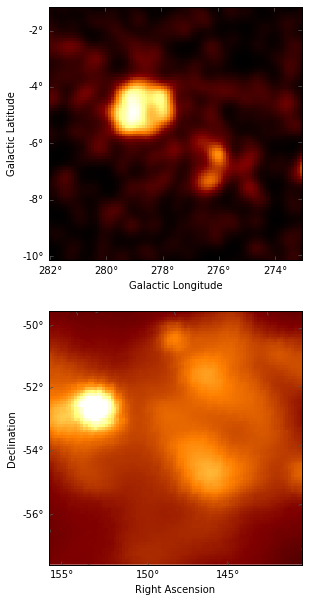

In [5]:
### Reproject WMAP image on Fermi image WCS
reproj_wmap = vela_wmap.reproject(vela_smooth)

# Image center
center = SkyCoord(265.0*u.deg,-2.0*u.deg,frame='galactic')
size = 9.0*u.deg


# Now plot
fig = plt.figure(figsize=(7,10))
ax1 = fig.add_subplot(2, 1, 1, projection=vela_smooth.wcs)
vela_smooth.cutout(center,size).plot(ax=ax1,cmap='afmhot')

ax2 = fig.add_subplot(2, 1, 2, projection=vela_wmap.wcs)
reproj_wmap.cutout(center,size).plot(ax=ax2,cmap='afmhot',norm=norm)



## Spectrum

- Plot the spectra
- Also plot event energy distributions

In [6]:
source = cat['2FHL J0534.5+2201'] # Crab nebula

<Table length=360>
            name             dtype  shape n_bad
--------------------------- ------- ----- -----
                Source_Name   str18           0
                    RAJ2000 float32           0
                    DEJ2000 float32           0
                       GLON float32           0
                       GLAT float32           0
                 Pos_err_68 float32           0
                         TS float32           0
             Spectral_Index float32           0
         Unc_Spectral_Index float32           1
    Intr_Spectral_Index_D11 float32         232
Unc_Intr_Spectral_Index_D11 float32         233
    Intr_Spectral_Index_G12 float32         232
Unc_Intr_Spectral_Index_G12 float32         233
                     Flux50 float32           0
                 Unc_Flux50 float32           0
              Energy_Flux50 float32           0
          Unc_Energy_Flux50 float32           0
              Flux50_171GeV float32           0
          Unc_Flux50_

/Users/terrier/Code/anaconda2/lib/python2.7/site-packages/astropy/table/column.py:263: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self.data.__eq__(other)
/Users/terrier/Code/anaconda2/lib/python2.7/site-packages/astropy/table/info.py:93: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if np.all(info[name] == ''):


Flux points of type 'dnde'


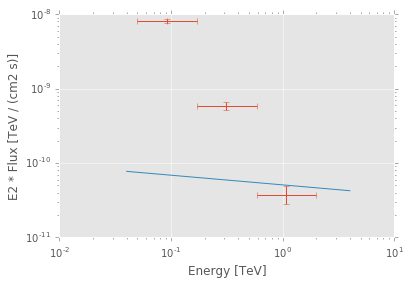

In [7]:
energy_range = [50 * u.GeV, 1 * u.TeV]
print(source.flux_points)
source.flux_points.plot()
# source.spectrum.butterfly.plot()
source.spectral_model.plot(energy_range=[40, 4000] * u.GeV, energy_power=2)

## Light curve

- Plot light curve
- Plot event time histogram

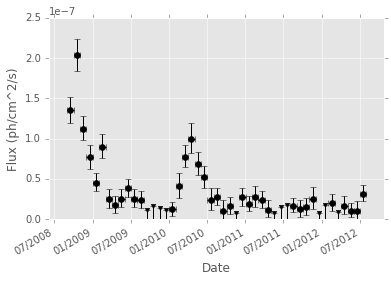

In [8]:
from gammapy.time import plot_fermi_3fgl_light_curve
# This is an example from 3FGL
# TODO: refactor this code and make it work for 2FHL also
plot_fermi_3fgl_light_curve('3FGL J0349.9-2102')

## Exercises

TODO: describe one or more small exercises.

E.g. look at some other source and do the same analysis as above

## What next?

This was a quick introduction to some of the high-level classes in Astropy and Gammapy.

* To learn more about those classes, go to the API docs (links are in the introduction at the top).
* To learn more about other parts of Gammapy (e.g. Fermi-LAT and TeV data analysis), check out the other tutorial notebooks.
* To see what's available in Gammapy, browse the [Gammapy docs](http://docs.gammapy.org/) or use the full-text search.
* If you have any questions, ask on the mailing list.